# Introduction

The purpose of the notebook is to introduce the way of choosing number of optimal LSTM models and training process. 

Given 985 datasets, it is not practical to train 985 LSTM models on each since it requires a lot of time and memory. However, there is an interesting assumption that some datasets have the approximately same patterns. So the question arises why not to train one model that is capable of generalizing all **n** similar datasets? In order to choose number of similar datasets, it is required to use clustering method. Here, we propose KMeans clustering to apply and conclude that 3 LSTM models can be trained.

We determined that the optimal number of LSTM models should be 3. We constructed 3 models accordingly and trained. During timeseries generation, all samples in the same cluster were concatenated with batch size of 64.

The notebook was divided into two parts namely Geo Clustering and Timeseries Forecasting.

# Importing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import pickle

# Geo Clustering

## Data Preparation

Reading data. 

Description contains overall representations of each original dataset. Locations are also provided accordingly.

In [2]:
description = pd.read_csv('../data/description/descriptions.csv')
locations = pd.read_csv('../data/locations/locations.csv')

In [3]:
locations

,Latitude,Longitude
0,38.93,46.58
1,38.97,46.58
2,38.97,46.50
3,38.97,46.62
4,38.97,46.66
...,...,...
980,40.49,47.10
981,40.49,47.22
982,40.49,47.26
983,40.53,47.18


In [4]:
locations = locations.values

In [5]:
description.head()

,GHI_mean,GHI_std,GHI_min,GHI_25%,GHI_50%,GHI_75%,GHI_max,Surface Albedo_mean,Surface Albedo_std,Surface Albedo_min,...,Relative Humidity_50%,Relative Humidity_75%,Relative Humidity_max,Power_mean,Power_std,Power_min,Power_25%,Power_50%,Power_75%,Power_max
0,177.898402,274.006607,0.0,0.0,0.0,293.00,1012.0,0.177014,0.038765,0.14,...,54.370,69.5225,87.78,64.709378,95.301811,-0.075,-0.075,-0.075,124.312334,250.0
1,175.784361,273.346794,0.0,0.0,0.0,283.00,1014.0,0.126110,0.047281,0.08,...,57.075,72.9425,92.33,63.447956,94.605336,-0.075,-0.075,-0.075,116.756273,250.0
2,186.398059,281.324998,0.0,0.0,0.0,307.00,1040.0,0.354575,0.318808,0.10,...,75.420,96.7925,100.00,69.334708,97.986571,-0.075,-0.075,-0.075,139.498283,250.0
3,175.050913,271.423642,0.0,0.0,0.0,286.00,1005.0,0.151260,0.040493,0.10,...,52.450,67.1000,84.57,63.488635,94.458014,-0.075,-0.075,-0.075,119.638345,250.0
4,175.652055,271.681464,0.0,0.0,0.0,289.25,997.0,0.160767,0.038954,0.13,...,51.470,65.5700,82.05,63.953455,94.973616,-0.075,-0.075,-0.075,121.315859,250.0


Although initially we were not quite sure which feature should be chosen, we were then agreed by only mean and standard deviation of power columns of each datasets since we are aiming to forecast power in the second part of notebook.

In [6]:
cols = ['Power_mean', 'Power_std']
df = description[cols]

## KMeans Clustering

### Scaling

In [7]:
scaler = MinMaxScaler().fit(df)
scaled_data = scaler.transform(df)

In [8]:
scaled_data.shape

(985, 2)

### Clustering

In [9]:
models = []
inertias = []
for n_clustes in range(2, 10):
    model = KMeans(n_clusters = n_clustes, n_init = 'auto').fit(scaled_data)
    models += [model]
    inertias += [model.inertia_]

Elbow plot seems to be incorrect here. Therefore we made another approach with silhouette analysis.

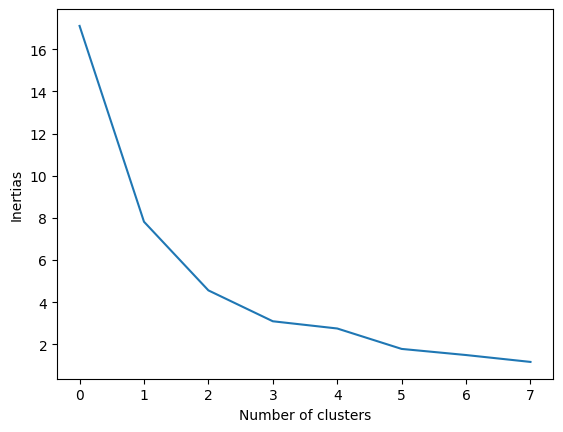

In [10]:
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.plot(inertias)

The source code can be found [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).
It can be observed that starting from n_clusters = 4 negative scores slightly appears. Thus, n_clusters = 3 becomes the best case.

For n_clusters = 2 The average silhouette_score is : 0.7052976979275718
For n_clusters = 3 The average silhouette_score is : 0.5482952569749753
For n_clusters = 4 The average silhouette_score is : 0.5479958198741403
For n_clusters = 5 The average silhouette_score is : 0.5540279842067755
For n_clusters = 6 The average silhouette_score is : 0.526059103660059
For n_clusters = 7 The average silhouette_score is : 0.504802266866573
For n_clusters = 8 The average silhouette_score is : 0.4999249010812237
For n_clusters = 9 The average silhouette_score is : 0.49093994997773754


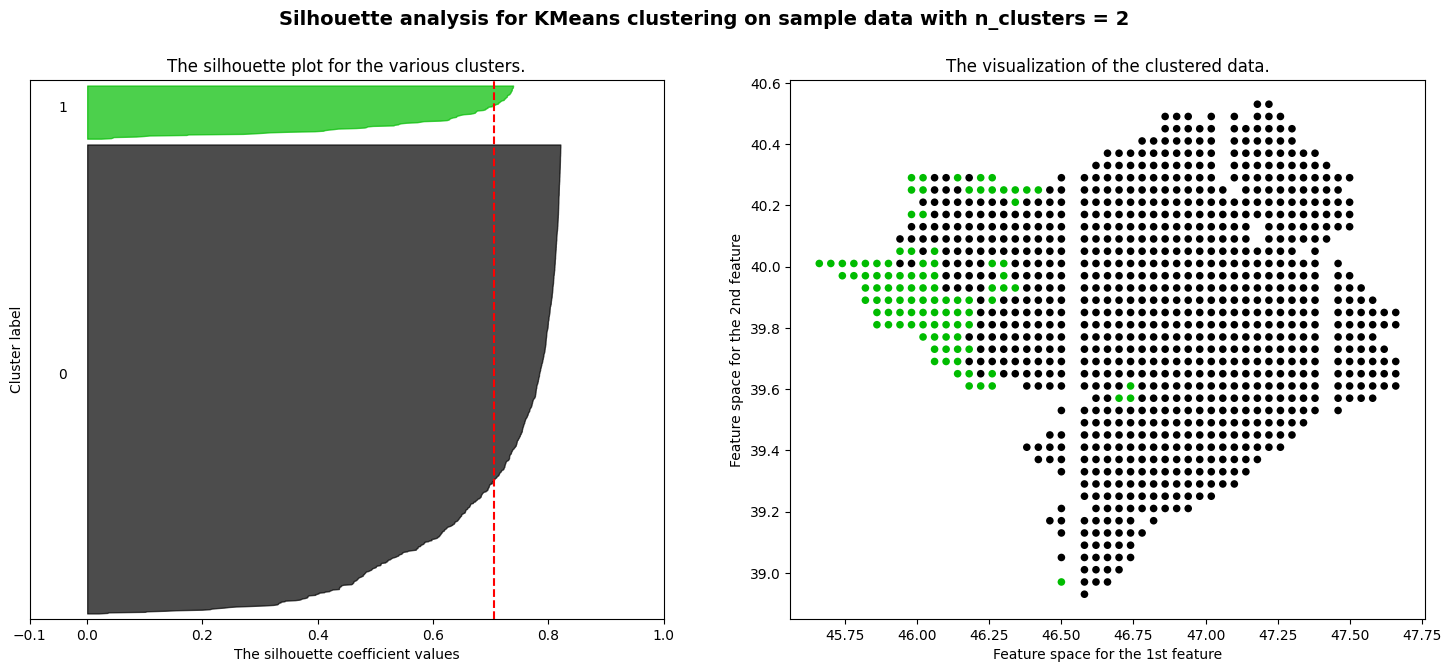

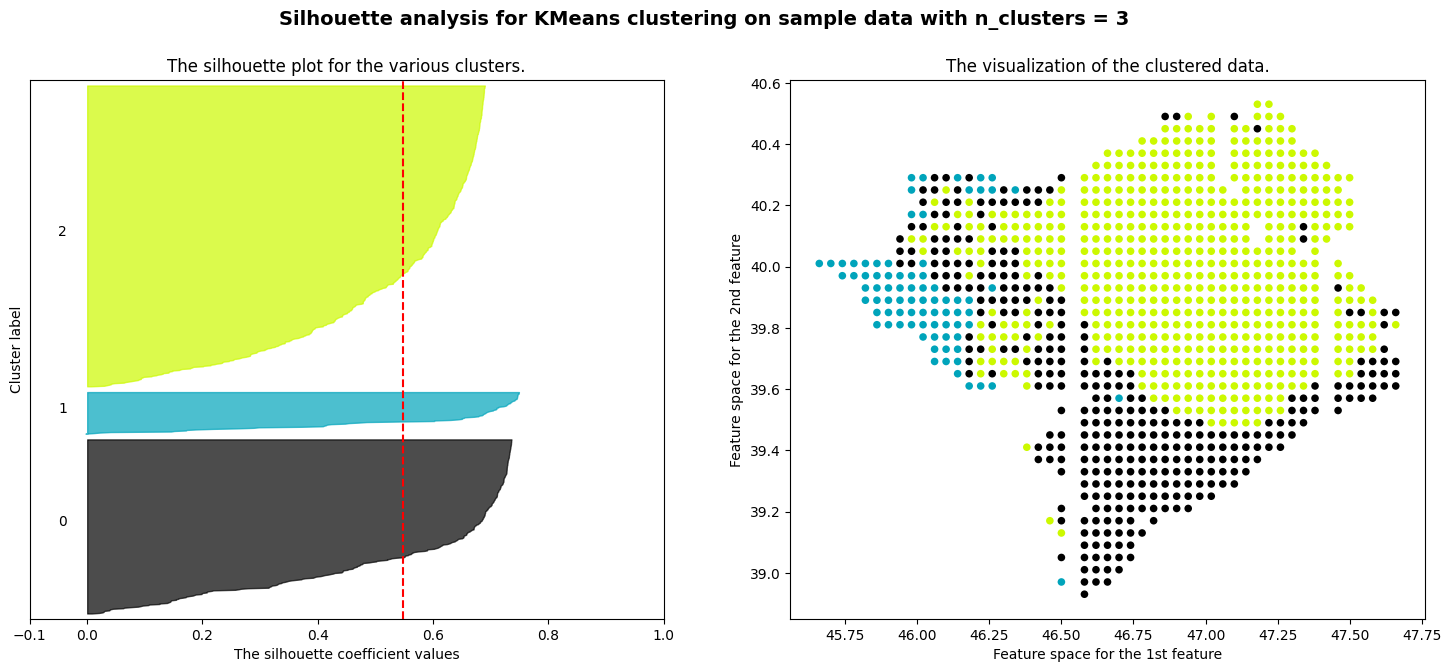

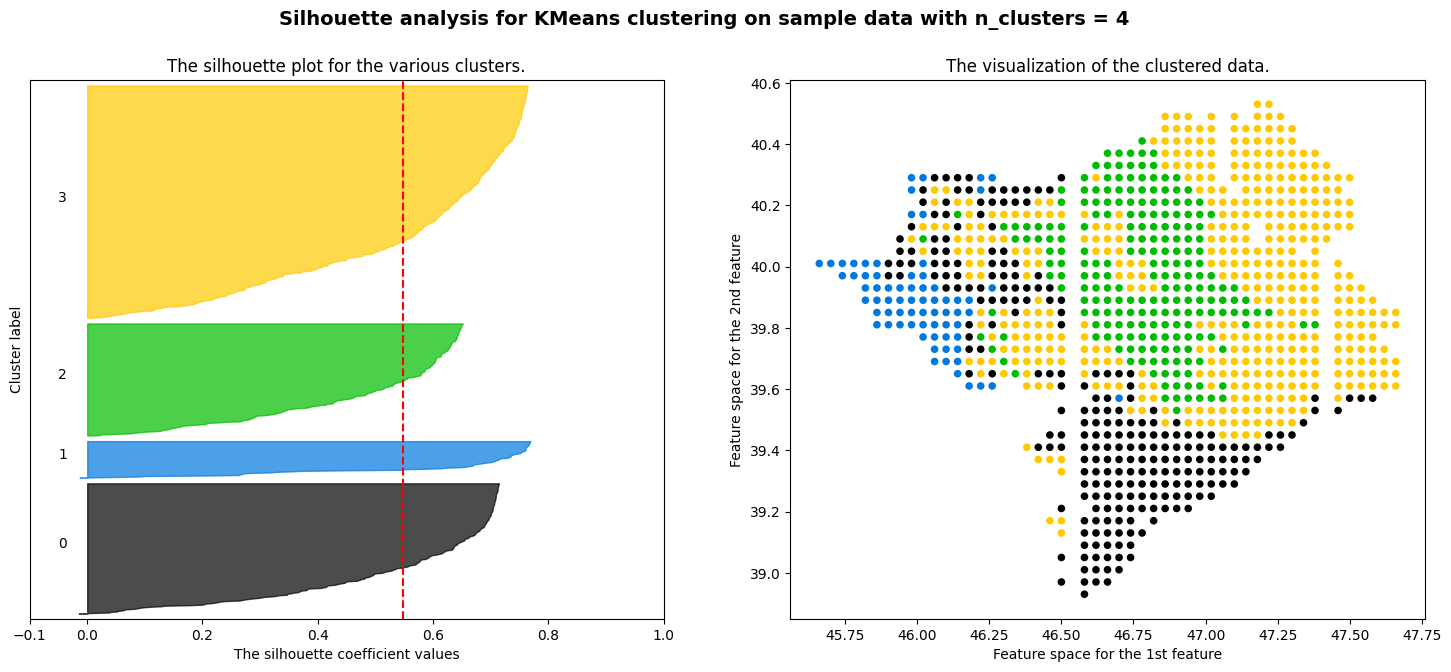

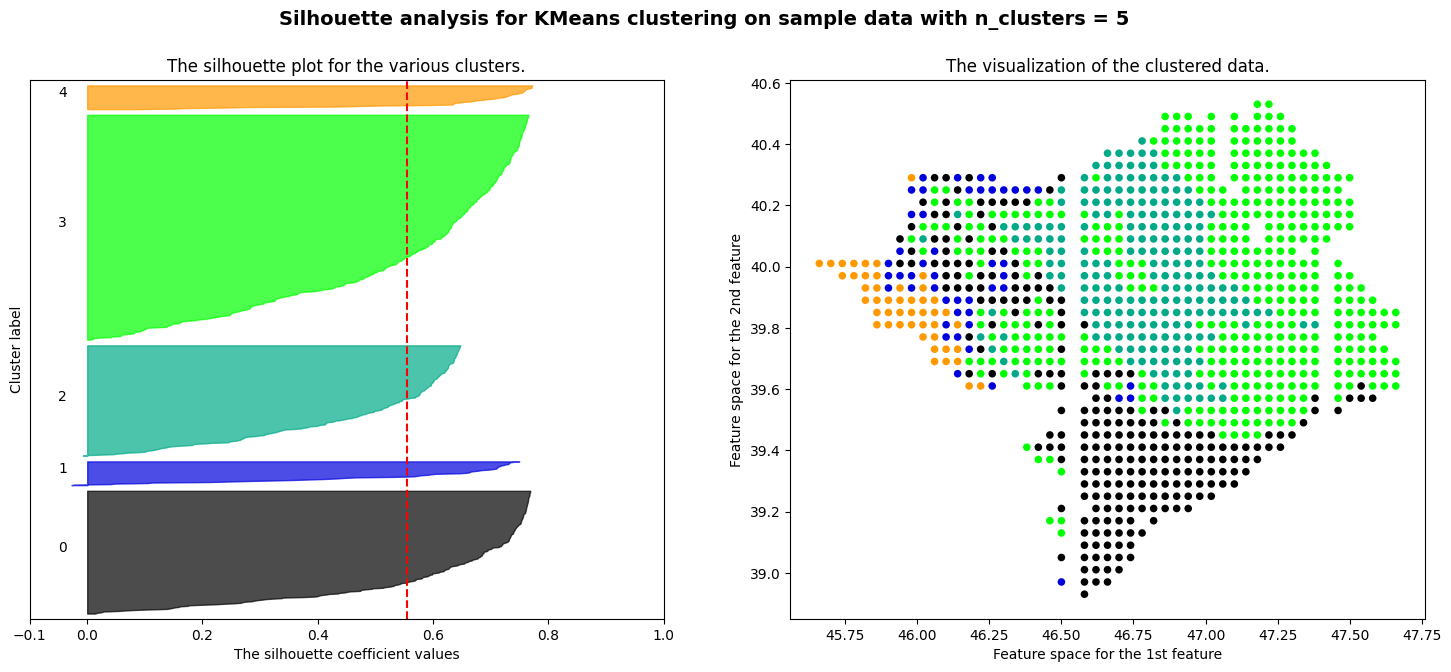

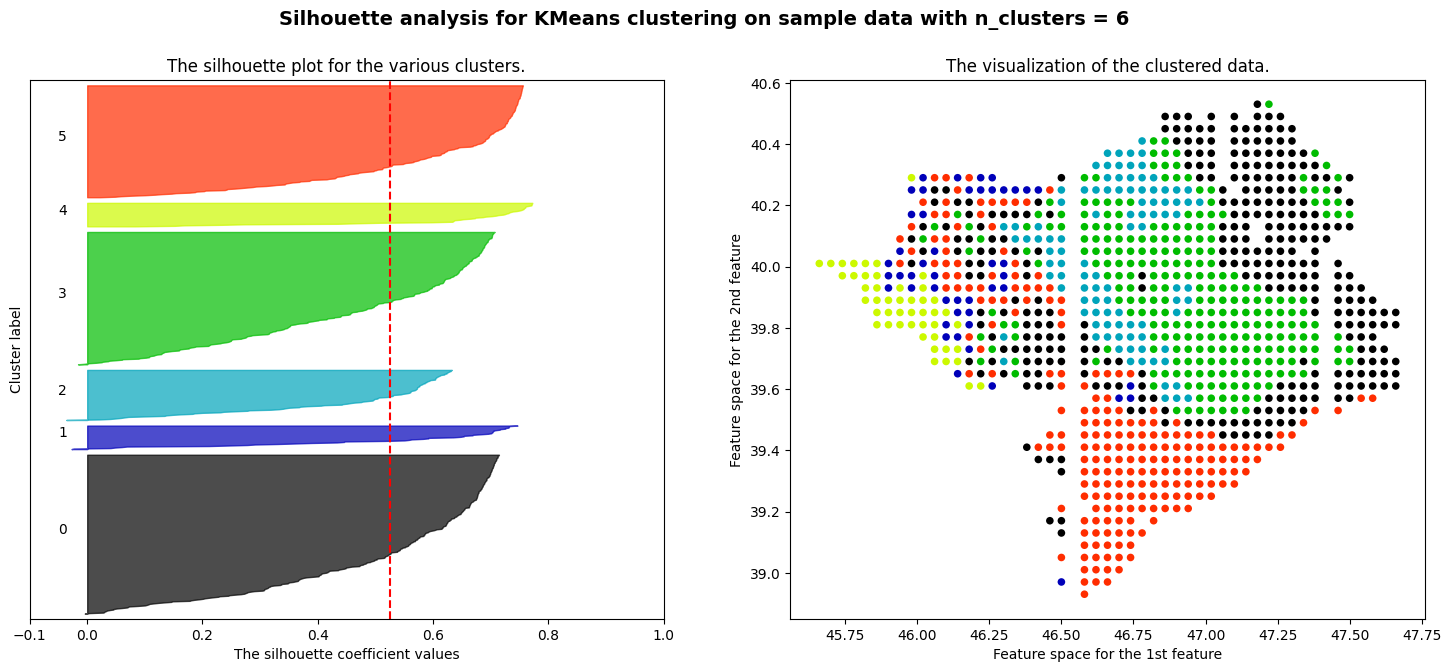

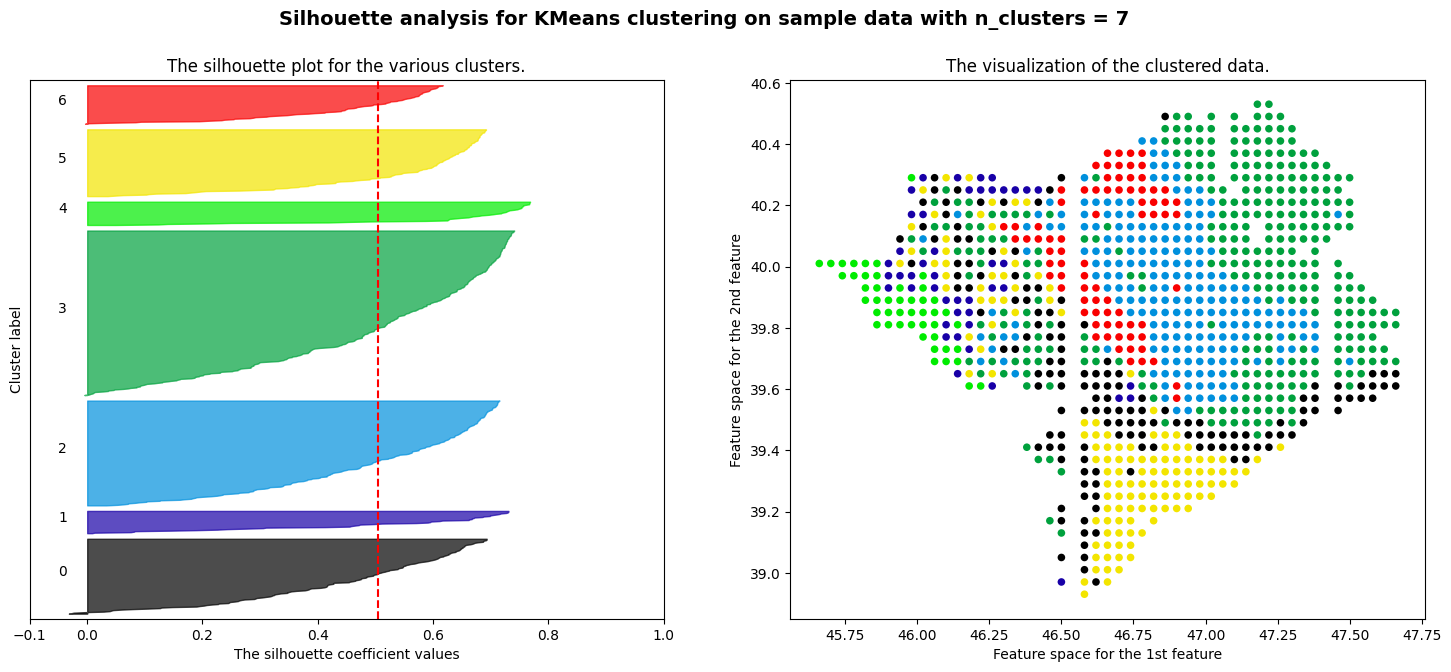

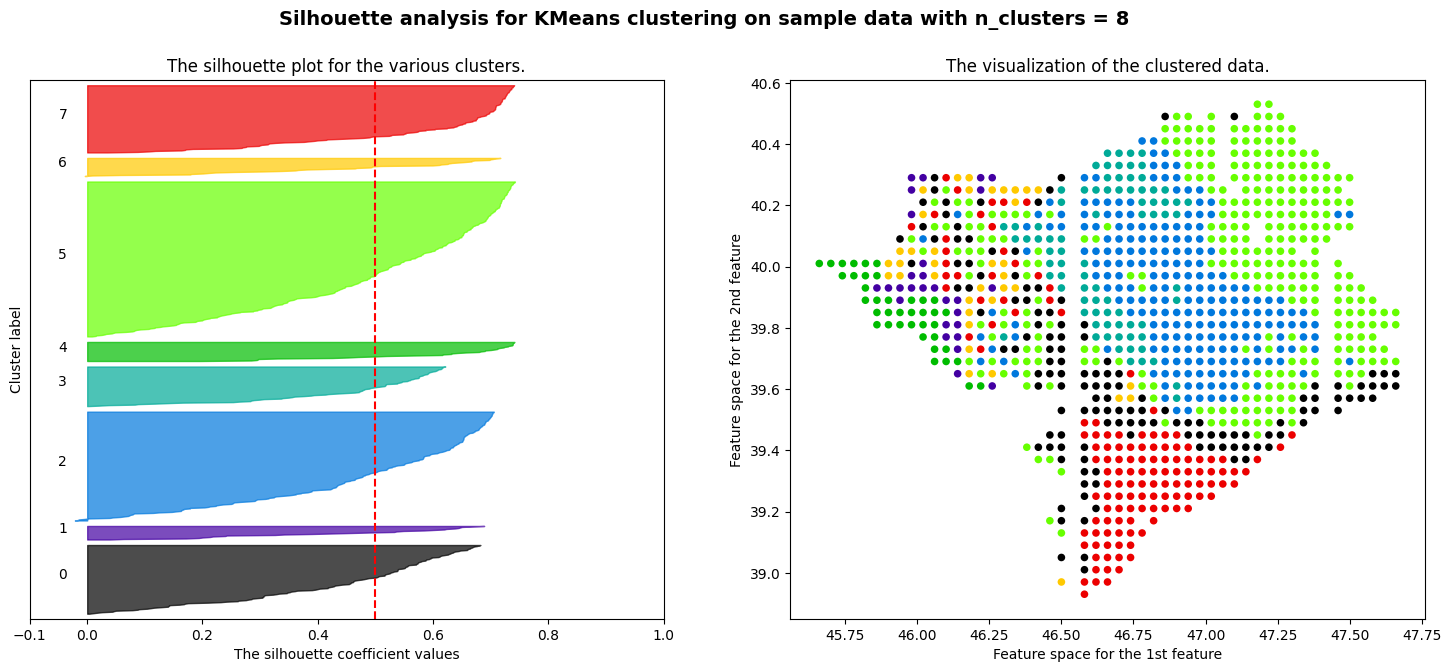

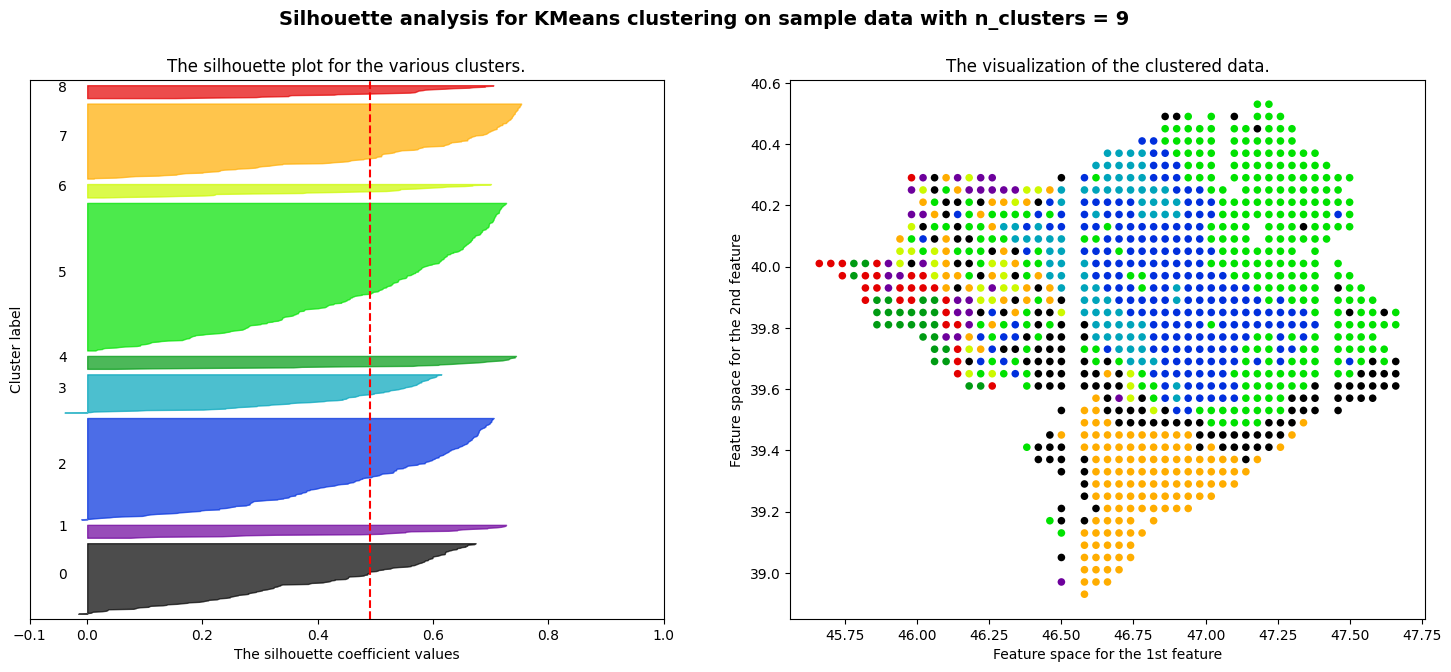

In [11]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together

all_clusters = list(range(2, 10, 1))

for n_clusters in all_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10).fit(scaled_data)
    cluster_labels = clusterer.predict(scaled_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        locations[:, 1], locations[:, 0], s=30, lw=0, alpha=1, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

    plt.savefig('images/Silhouette Analysis {}.png'.format(n_clusters))
plt.show()

Preparing the final model with 3 clusters.

In [12]:
model = KMeans(n_clusters = 3, n_init = 'auto').fit(scaled_data)

Text(0, 0.5, 'Latitude')

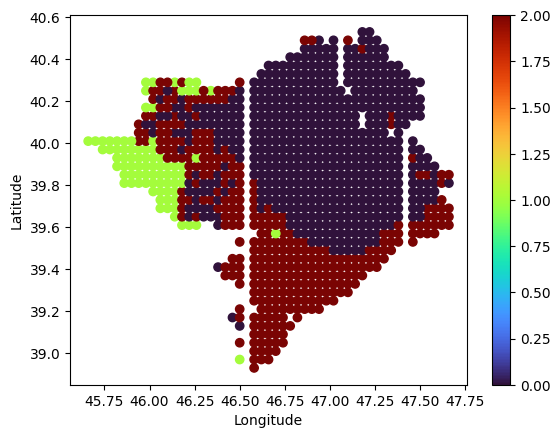

In [13]:
plt.scatter(locations[:, 1], locations[:, 0], cmap = 'turbo', c = model.labels_)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Saving model and findings

Saving KMeans model.

In [14]:
f = open('../models/KMeans', 'wb')
pickle.dump(model, f)
f.close()

Saving clustered labels.

In [15]:
labels = np.expand_dims(model.labels_, 1)
labels = np.concatenate((locations, labels), axis = 1)
labels = pd.DataFrame(labels, columns = ['Latitude', 'Longitude', 'Labels'])
labels.to_csv('../data/labeled_data/labeled_data.csv', index = False)

In [17]:
labels.head()

,Latitude,Longitude,Labels
0,38.93,46.58,2.0
1,38.97,46.58,2.0
2,38.97,46.50,1.0
3,38.97,46.62,2.0
4,38.97,46.66,2.0


# Timeseries Forecasting

Loading data to the notebook. You can download data from [here](https://drive.google.com/drive/folders/1OyEpt88KUn4oc12tA5mUDVji60pP_xsc?usp=sharing).

In [18]:
filepath = '../data/timeseries data/'
filenames = os.listdir(filepath)
data = np.zeros((len(filenames), 8760))

for i, filename in enumerate(filenames):
    row = pd.read_csv(filepath + filename)['Power'].values
    data[i] = row

del row

Reading pre-defined labels.

In [19]:
labels = pd.read_csv('../data/labeled_data/labeled_data.csv')

In [20]:
labels.head()

,Latitude,Longitude,Labels
0,38.93,46.58,2.0
1,38.97,46.58,2.0
2,38.97,46.50,1.0
3,38.97,46.62,2.0
4,38.97,46.66,2.0


In [22]:
# 2 - intermedia frequencies
value_counts = labels.Labels.value_counts()
value_counts

Labels
0.0    573
2.0    332
1.0     80
Name: count, dtype: int64

We detected that one label have extremely lower counts compared to others. The following manipulation is done in order to define train_size accordingly in splitting part.

In [23]:
index = value_counts.index
values = value_counts.values

In [24]:
indexes = values.argsort()

In [25]:
index = index[indexes]

Choosing data for each label.

In [26]:
labeled_data_0 = data[(labels.Labels == 0).values]
labeled_data_1 = data[(labels.Labels == 1).values]
labeled_data_2 = data[(labels.Labels == 2).values]

Because datasets in the same cluster have similar patterns, they are combined as one dataset and scaled, and later reshaping is conducted to bring back the prior shape.

In [27]:
scaler_0 = MinMaxScaler().fit(labeled_data_0.reshape(-1, 1))
scaled_data_0 = scaler_0.transform(labeled_data_0.reshape(-1, 1))
scaled_data_0 = scaled_data_0.reshape(labeled_data_0.shape)

scaler_1 = MinMaxScaler().fit(labeled_data_1.reshape(-1, 1))
scaled_data_1 = scaler_1.transform(labeled_data_1.reshape(-1, 1))
scaled_data_1 = scaled_data_1.reshape(labeled_data_1.shape)

scaler_2 = MinMaxScaler().fit(labeled_data_2.reshape(-1, 1))
scaled_data_2 = scaler_2.transform(labeled_data_2.reshape(-1, 1))
scaled_data_2 = scaled_data_2.reshape(labeled_data_2.shape)


Splitting datasets. (Don't ask how it works. It is hard to explain. Just consider that we are trying to put optimal train_size to each of scaled data)

In [28]:
train_sizes = np.array([0.75, 0.30, 0.18])

for i in range(3):
    if index[i] == 0:
        train_size = train_sizes[i]
        train_0, test_0 = train_test_split(scaled_data_0, train_size = train_size)

    if index[i] == 1:
        train_size = train_sizes[i]
        train_1, test_1 = train_test_split(scaled_data_1, train_size = train_size)

    if index[i] == 2:
        train_size = train_sizes[i]
        train_2, test_2 = train_test_split(scaled_data_2, train_size = train_size)

In [29]:
train_0.shape, test_0.shape

((103, 8760), (470, 8760))

In [30]:
train_1.shape, test_1.shape

((60, 8760), (20, 8760))

In [31]:
train_2.shape, test_2.shape

((99, 8760), (233, 8760))

The function of timeseries generator. It is only designed for single variate output.

In [32]:
def timeseries_generator(orig_data, lookback, batch_size = 1):
    orig_data = orig_data.tolist()
    X = []
    y = []
    n = (len(orig_data) - lookback) // batch_size
    
    for i in range(n):
        temp_X = []
        temp_y = []
        
        for j in range(batch_size):
            start_index = i * batch_size + j
            end_index = i * batch_size + j + lookback
            
            temp_X += [orig_data[start_index: end_index]]
            temp_y += [orig_data[end_index: end_index + 1]]
        
        X += [temp_X]
        y += [temp_y]
        
    return X, y

Formatting data for LSTM input

In [33]:
lookback = 24
batch_size = 64

In [160]:
train_X_0 = []
train_y_0 = []
test_X_0 = []
test_y_0 = []

for i in range(train_0.shape[0]):
    Xi, yi = timeseries_generator(train_0[i], lookback, batch_size = batch_size)
    train_X_0 += Xi
    train_y_0 += yi
    
for i in range(test_0.shape[0]):
    Xi, yi = timeseries_generator(test_0[i], lookback, batch_size = batch_size)
    test_X_0 += Xi
    test_y_0 += yi

In [163]:
train_X_1 = []
train_y_1 = []
test_X_1 = []
test_y_1 = []

for i in range(train_1.shape[0]):
    Xi, yi = timeseries_generator(train_1[i], lookback, batch_size = batch_size)
    train_X_1 += Xi
    train_y_1 += yi
    
for i in range(test_1.shape[0]):
    Xi, yi = timeseries_generator(test_1[i], lookback, batch_size = batch_size)
    test_X_1 += Xi
    test_y_1 += yi

In [34]:
train_X_2 = []
train_y_2 = []
test_X_2 = []
test_y_2 = []

for i in range(train_2.shape[0]):
    Xi, yi = timeseries_generator(train_2[i], lookback, batch_size = batch_size)
    train_X_2 += Xi
    train_y_2 += yi
    
for i in range(test_2.shape[0]):
    Xi, yi = timeseries_generator(test_2[i], lookback, batch_size = batch_size)
    test_X_2 += Xi
    test_y_2 += yi

Converting them to tensors.

In [161]:
train_X_0 = torch.Tensor(train_X_0)
train_y_0 = torch.Tensor(train_y_0)
test_X_0 = torch.Tensor(test_X_0)
test_y_0 = torch.Tensor(test_y_0)

In [165]:
train_X_1 = torch.Tensor(train_X_1)
train_y_1 = torch.Tensor(train_y_1)
test_X_1 = torch.Tensor(test_X_1)
test_y_1 = torch.Tensor(test_y_1)

In [35]:
train_X_2 = torch.Tensor(train_X_2)
train_y_2 = torch.Tensor(train_y_2)
test_X_2 = torch.Tensor(test_X_2)
test_y_2 = torch.Tensor(test_y_2)

In [162]:
train_X_0.shape

torch.Size([7752, 64, 24])

In [166]:
train_X_1.shape

torch.Size([14144, 64, 24])

In [36]:
train_X_2.shape

torch.Size([13464, 64, 24])

Sometimes shapes of test set are extremely big. Therefore, we set some conditions to make random choices from test set in order to decrease unnecessary size of 0th dimension. This will help to overcome time complexity issues in the evaluation of the trained model.

In [176]:
if test_X_0.shape[0] > 20000:
    indexes = np.unique(np.random.choice(range(test_X_0.shape[0]), size = train_X_0.shape[0]))
    test_X_0 = test_X_0[indexes]
    test_y_0 = test_y_0[indexes]
    
train_X_0.shape, test_X_0.shape, test_y_0.shape

(torch.Size([7752, 64, 24]),
 torch.Size([2584, 64, 24]),
 torch.Size([2584, 64, 1]))

In [174]:
if test_X_1.shape[0] > 20000:
    indexes = np.unique(np.random.choice(range(test_X_1.shape[0]), size = train_X_1.shape[0]))
    test_X_1 = test_X_1[indexes]
    test_y_1 = test_y_1[indexes]
    
train_X_1.shape, test_X_1.shape, test_y_1.shape

(torch.Size([14144, 64, 24]),
 torch.Size([12752, 64, 24]),
 torch.Size([12752, 64, 1]))

In [39]:
if test_X_2.shape[0] > 20000:
    indexes = np.unique(np.random.choice(range(test_X_2.shape[0]), size = train_X_2.shape[0]))
    test_X_2 = test_X_2[indexes]
    test_y_2 = test_y_2[indexes]
    
train_X_2.shape, train_y_2.shape, test_X_2.shape, test_y_2.shape

(torch.Size([13464, 64, 24]),
 torch.Size([13464, 64, 1]),
 torch.Size([10980, 64, 24]),
 torch.Size([10980, 64, 1]))

# Modeling

In [40]:
class TimeseriesForecaster(nn.Module):
    def __init__(self, lookback, num_layers, feature):
        super().__init__()
        torch.random.manual_seed(42)
        
        self.lstm1 = nn.LSTM(input_size = lookback, hidden_size = feature, num_layers = num_layers)
        self.fc1 = nn.Linear(feature, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.lstm1(x)[0])
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [41]:
model_0 = TimeseriesForecaster(lookback = lookback, num_layers = 2, feature = 32).to('cpu')
model_1 = TimeseriesForecaster(lookback = lookback, num_layers = 2, feature = 32).to('cpu')
model_2 = TimeseriesForecaster(lookback = lookback, num_layers = 2, feature = 32).to('cpu')

In [314]:
model_0(train_X_0[0]).shape

torch.Size([64, 1])

In [44]:
loss_fn = torch.nn.MSELoss(reduction='mean')

In [43]:
optimizer_0 = torch.optim.Adam(model_0.parameters(), lr=1e-3)

In [54]:
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)

In [45]:
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)

Functions to train and evaluate

In [46]:
def train_model(model, trainloader, optimizer, loss_fn, n, epoch):
    model.train()
    m = 1000
    train_loss = 0
    total_train_loss = 0
    
    for i, (X, y) in enumerate(trainloader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if i % m == m - 1:
            print('{} Epoch --> {}/{} with loss of {:.5f}'.format(
                    epoch + 1, i + 1, n, train_loss / m 
                    ))
            total_train_loss += train_loss
            train_loss = 0
    return total_train_loss / n
            
def evaluate_model(model, testloader, loss_fn, n):
    model.eval()
    with torch.no_grad():
        total_test_loss = 0

        for X, y in testloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            total_test_loss += loss.item()

        return total_test_loss / n

In [47]:
def main(train_X, train_y, test_X, test_y, model, optimizer, loss_fn, epochs, threshold):
    earlier_stop = -1
    prior_test_loss = 0
    history = []
    for epoch in range(epochs):
        print('-' * 50)

        trainloader = zip(train_X, train_y)
        testloader = zip(test_X, test_y)

        train_loss = train_model(model, trainloader, optimizer, loss_fn, n = train_X.shape[0], epoch = epoch)
        print('\nAverage train loss error --> {:.5f}'.format(train_loss))

        test_loss = evaluate_model(model, testloader, loss_fn, n = test_X.shape[0])
        print('Average test loss error --> {:.5f}\n'.format(test_loss))

        if test_loss > prior_test_loss:
            earlier_stop += 1
            prior_test_loss = test_loss

            if threshold <= earlier_stop:
                break
        history.append([train_loss, test_loss])
    
    return history

In [337]:
history_0 = main(train_X_0, train_y_0, test_X_0, test_y_0, model_0, optimizer_0, loss_fn, epochs = 20, threshold = 5)

--------------------------------------------------
1 Epoch --> 1000/7752 with loss of 0.02087
1 Epoch --> 2000/7752 with loss of 0.02028
1 Epoch --> 3000/7752 with loss of 0.01930
1 Epoch --> 4000/7752 with loss of 0.02001
1 Epoch --> 5000/7752 with loss of 0.02028
1 Epoch --> 6000/7752 with loss of 0.02045
1 Epoch --> 7000/7752 with loss of 0.02014

Average train loss error --> 0.01823
Average test loss error --> 0.02148

--------------------------------------------------
2 Epoch --> 1000/7752 with loss of 0.01995
2 Epoch --> 2000/7752 with loss of 0.01928
2 Epoch --> 3000/7752 with loss of 0.01850
2 Epoch --> 4000/7752 with loss of 0.01935
2 Epoch --> 5000/7752 with loss of 0.01955
2 Epoch --> 6000/7752 with loss of 0.01982
2 Epoch --> 7000/7752 with loss of 0.01958

Average train loss error --> 0.01755
Average test loss error --> 0.02005

--------------------------------------------------
3 Epoch --> 1000/7752 with loss of 0.01955
3 Epoch --> 2000/7752 with loss of 0.01879
3 Epoch -

20 Epoch --> 1000/7752 with loss of 0.01780
20 Epoch --> 2000/7752 with loss of 0.01493
20 Epoch --> 3000/7752 with loss of 0.01392
20 Epoch --> 4000/7752 with loss of 0.01446
20 Epoch --> 5000/7752 with loss of 0.01501
20 Epoch --> 6000/7752 with loss of 0.01497
20 Epoch --> 7000/7752 with loss of 0.01575

Average train loss error --> 0.01378
Average test loss error --> 0.01689



In [178]:
history_1 = main(train_X_1, train_y_1, test_X_1, test_y_1, model_1, optimizer_1, loss_fn, epochs = 10, threshold = 3)

--------------------------------------------------
1 Epoch --> 1000/14144 with loss of 0.01433
1 Epoch --> 2000/14144 with loss of 0.01427
1 Epoch --> 3000/14144 with loss of 0.01371
1 Epoch --> 4000/14144 with loss of 0.01404
1 Epoch --> 5000/14144 with loss of 0.01417
1 Epoch --> 6000/14144 with loss of 0.01339
1 Epoch --> 7000/14144 with loss of 0.01370
1 Epoch --> 8000/14144 with loss of 0.01343
1 Epoch --> 9000/14144 with loss of 0.01253
1 Epoch --> 10000/14144 with loss of 0.01397
1 Epoch --> 11000/14144 with loss of 0.01381
1 Epoch --> 12000/14144 with loss of 0.01334
1 Epoch --> 13000/14144 with loss of 0.01300
1 Epoch --> 14000/14144 with loss of 0.01355

Average train loss error --> 0.01352
Average test loss error --> 0.01376

--------------------------------------------------
2 Epoch --> 1000/14144 with loss of 0.01344
2 Epoch --> 2000/14144 with loss of 0.01381
2 Epoch --> 3000/14144 with loss of 0.01287
2 Epoch --> 4000/14144 with loss of 0.01347
2 Epoch --> 5000/14144 wit

In [49]:
history_2 = main(train_X_2, train_y_2, test_X_2, test_y_2, model_2, optimizer_2, loss_fn, epochs = 10, threshold = 3)

--------------------------------------------------
1 Epoch --> 1000/13464 with loss of 0.03657
1 Epoch --> 2000/13464 with loss of 0.01682
1 Epoch --> 3000/13464 with loss of 0.01671
1 Epoch --> 4000/13464 with loss of 0.01522
1 Epoch --> 5000/13464 with loss of 0.01672
1 Epoch --> 6000/13464 with loss of 0.01663
1 Epoch --> 7000/13464 with loss of 0.01864
1 Epoch --> 8000/13464 with loss of 0.01880
1 Epoch --> 9000/13464 with loss of 0.01675
1 Epoch --> 10000/13464 with loss of 0.01606
1 Epoch --> 11000/13464 with loss of 0.01565
1 Epoch --> 12000/13464 with loss of 0.01503
1 Epoch --> 13000/13464 with loss of 0.01542

Average train loss error --> 0.01745
Average test loss error --> 0.01903

--------------------------------------------------
2 Epoch --> 1000/13464 with loss of 0.01598
2 Epoch --> 2000/13464 with loss of 0.01479
2 Epoch --> 3000/13464 with loss of 0.01487
2 Epoch --> 4000/13464 with loss of 0.01371
2 Epoch --> 5000/13464 with loss of 0.01535
2 Epoch --> 6000/13464 with

## Results Analysis

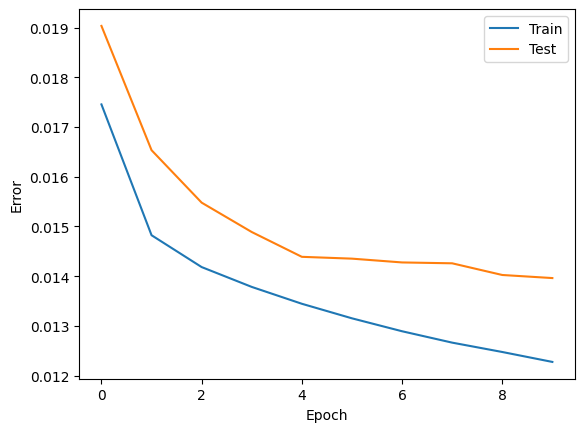

In [50]:
train_history_2 = [error[0] for error in history_2]
test_history_2 = [error[1] for error in history_2]

plt.plot(train_history_2, label = 'Train')
plt.plot(test_history_2, label = 'Test')

plt.ylabel('Error')
plt.xlabel('Epoch')

plt.legend()

In [52]:
train_X_2.shape, test_X_2.shape

(torch.Size([13464, 64, 24]), torch.Size([10980, 64, 24]))

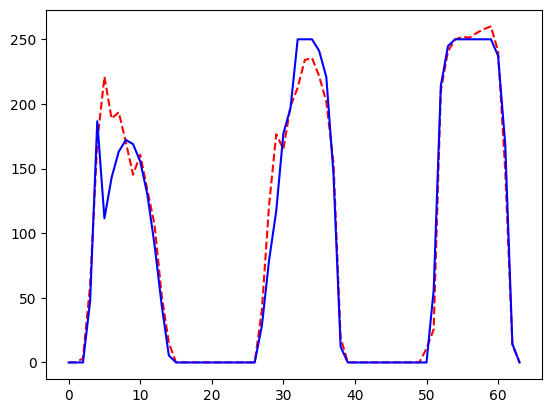

In [65]:
i = 2000
output = model_2(train_X_2[i]).detach().numpy()
labels = train_y_2[i].detach().numpy()
plt.plot(scaler_2.inverse_transform(output), linestyle = '--', color = 'red')
plt.plot(scaler_2.inverse_transform(labels), color = 'blue')

In [57]:
test_X_2.shape, test_y_2.shape

(torch.Size([10980, 64, 24]), torch.Size([10980, 64, 1]))

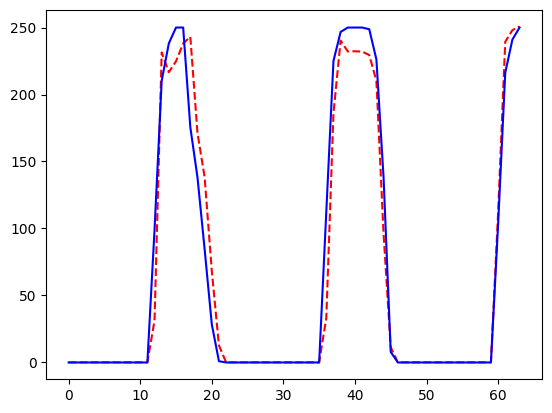

In [59]:
i = 3000
output = model_2(test_X_2[i]).detach().numpy()
labels = test_y_2[i].detach().numpy()
plt.plot(scaler_2.inverse_transform(output), linestyle = '--', color = 'red')
plt.plot(scaler_2.inverse_transform(labels), color = 'blue')

Results suggest the model is powerful enough but can be improved further with integrating outlier detection technique in data preparation step, replacing KMeans by Density Base Scan for more accurate clustering, and constructing better model architecture for each cluster of data.

## Saving and Reading models

In [362]:
torch.save(model_0.state_dict(), '../models/LSTM_0.dat')

In [179]:
torch.save(model_1.state_dict(), '../models/LSTM_1.dat')

In [60]:
torch.save(model_2.state_dict(), '../models/LSTM_2.dat')

In [365]:
model = TimeseriesForecaster(feature = 32, lookback = 24, num_layers = 2).to('cpu')
model.load_state_dict(torch.load('../models/LSTM_0.dat'))

<All keys matched successfully>

In [180]:
model = TimeseriesForecaster(feature = 32, lookback = 24, num_layers = 2).to('cpu')
model.load_state_dict(torch.load('../models/LSTM_1.dat'))

<All keys matched successfully>

In [61]:
model = TimeseriesForecaster(feature = 32, lookback = 24, num_layers = 2).to('cpu')
model.load_state_dict(torch.load('../models/LSTM_2.dat'))

<All keys matched successfully>